# SHAKTI FEniCS code

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

import matplotlib.pyplot as plt

In [2]:
import numpy as np
from dolfinx.mesh import create_rectangle, CellType
from dolfinx.fem import Function, FunctionSpace,Expression
from ufl import dx
from params import L,W,nx,ny,rho_i,g,H,resultsname,X,Y
from solvers import solve
from mpi4py import MPI
from fem_space import mixed_space, vector_space
from constitutive import potential
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

In [136]:
# Define domain
p0 = [-0.5*L,-0.5*W]
p1 = [0.5*L,0.5*W]
domain = create_rectangle(MPI.COMM_WORLD,[p0,p1], [nx, ny],cell_type=CellType.triangle) 

# define bed geometry
V0 = FunctionSpace(domain, ("CG", 1))
bed = lambda x: 0.02*(x[0]+0.5*L) - 100*np.exp(1)**(-((x[0]-0.25*W)**2+x[1]**2)/(2e3**2)) 
z_b = Function(V0)
z_b.interpolate(bed)

# define surface elevation
z_s = Function(V0)
surf = lambda x: 0.01*(x[0]+0.5*L) + H  -25*np.exp(1)**(-((x[0]-0.25*W)**2+x[1]**2)/(2e3**2)) 
z_s.interpolate(surf)

In [137]:
p,p_norm_ = potential(z_b,z_s)

p_norm = Function(V0)
px = Function(V0)
py = Function(V0)


p_norm.interpolate(Expression(p_norm_, V0.element.interpolation_points()))
px.interpolate(Expression(p[0], V0.element.interpolation_points()))
py.interpolate(Expression(p[1], V0.element.interpolation_points()))


points = domain.geometry.x[:,0:2]
triang = Delaunay(points)

p_norm_int = LinearNDInterpolator(triang, p_norm.x.array)(X,Y)
px_int = LinearNDInterpolator(triang, px.x.array)(X,Y)
py_int = LinearNDInterpolator(triang, py.x.array)(X,Y)
zb_int = LinearNDInterpolator(triang, z_b.x.array)(X,Y)
zs_int = LinearNDInterpolator(triang, z_s.x.array)(X,Y)

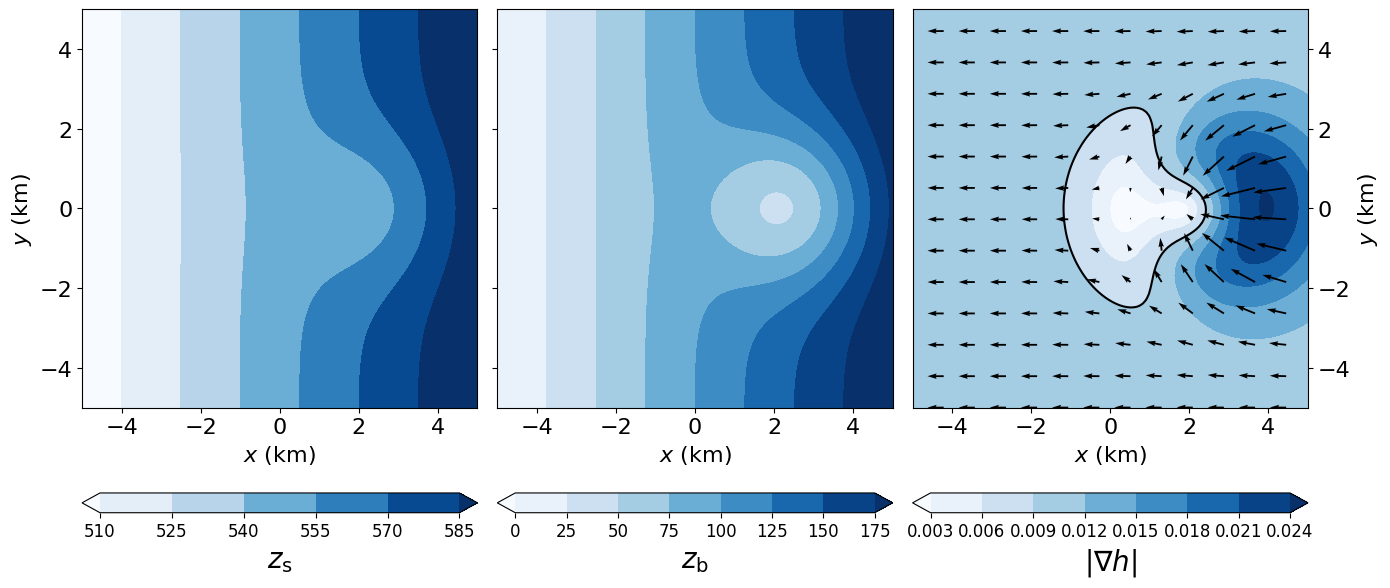

In [143]:
plt.figure(figsize=(14,6))
plt.subplot(131)
p1 = plt.contourf(X/1e3,Y/1e3,zs_int,cmap='Blues',extend='both')
cbar = plt.colorbar(p1, orientation='horizontal')
cbar.set_label(r'$z_\mathrm{s}$',fontsize=20)
cbar.ax.tick_params(labelsize=12)
plt.xlabel(r'$x$ (km)',fontsize=16)
plt.ylabel(r'$y$ (km)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.subplot(132)
p1 = plt.contourf(X/1e3,Y/1e3,zb_int,cmap='Blues',extend='both')
cbar = plt.colorbar(p1, orientation='horizontal')
cbar.set_label(r'$z_\mathrm{b}$',fontsize=20)
cbar.ax.tick_params(labelsize=12)
plt.xlabel(r'$x$ (km)',fontsize=16)
# plt.ylabel(r'$y$ (km)',fontsize=16)
plt.xticks(fontsize=16)
plt.gca().yaxis.set_ticklabels([])
plt.tight_layout()

plt.subplot(133)
p1 = plt.contourf(X/1e3,Y/1e3,p_norm_int,cmap='Blues',extend='both')
plt.contour(X/1e3,Y/1e3,p_norm_int,colors='k',levels=[0.009])
plt.quiver(X[::10,::10]/1e3,Y[::10,::10]/1e3,-px_int[::10,::10],-py_int[::10,::10])
cbar = plt.colorbar(p1, orientation='horizontal')
cbar.set_label(r'$|\nabla {h}|$',fontsize=20)
cbar.ax.tick_params(labelsize=12)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xlabel(r'$x$ (km)',fontsize=16)
plt.ylabel(r'$y$ (km)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()
plt.close()


In [123]:
p_norm_int.min()

0.0006049597613127136

In [149]:
sigma = 0.02/3.
storage = np.exp(1)**(-p_norm_int**8/sigma**8)

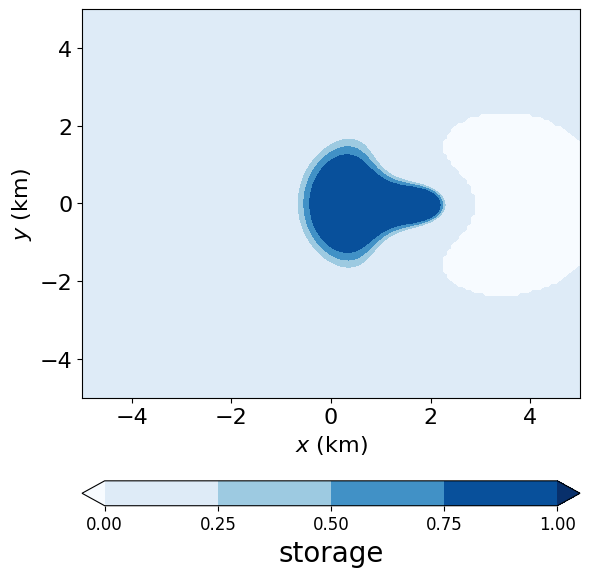

In [152]:
plt.figure(figsize=(6,6))
p1 = plt.contourf(X/1e3,Y/1e3,storage,cmap='Blues',levels=np.arange(0,1.1,0.25),extend='both')
cbar = plt.colorbar(p1, orientation='horizontal')
cbar.set_label(r'storage',fontsize=20)
cbar.ax.tick_params(labelsize=12)
plt.xlabel(r'$x$ (km)',fontsize=16)
plt.ylabel(r'$y$ (km)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

# 